Louay Medhat - 20201447561

Final Project: House Prices Prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import datetime

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV, Lasso
from sklearn.svm import SVR
from mlxtend.regressor import StackingRegressor
import lightgbm as lgbm

import numpy as np
from keras.layers import Dense, Activation
from keras.models import Sequential


from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# Load the files
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Get number of observations for test and train
print([len(x) for x in [train_df, test_df]])

# Combine it into one large file for data exploration and cleaning
combined_df = pd.concat([train_df, test_df])

# Get a first view
print(combined_df)

[1460, 1459]
        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1454  2915         160       RM         21.0     1936   Pave   NaN      Reg   
1455  2916         160       RM         21.0     1894   Pave   NaN      Reg   
1456  2917          20       RL        160.0    20000   Pave   NaN      Reg   
1457  2918          85       RL         62.0    10441   Pave   NaN      Reg   
1458  2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities  ... PoolAr

In [3]:
# Quick look at potential missing values
print(combined_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallCond  

In [29]:
print(combined_df.describe())

                Id  LotFrontage        LotArea  OverallQual  OverallCond  \
count  2919.000000  2919.000000    2919.000000  2919.000000  2919.000000   
mean   1460.000000    69.172913   10168.114080     6.089072     5.564577   
std     842.787043    21.592895    7886.996359     1.409947     1.113131   
min       1.000000    21.000000    1300.000000     1.000000     1.000000   
25%     730.500000    60.000000    7478.000000     5.000000     5.000000   
50%    1460.000000    67.205693    9453.000000     6.000000     5.000000   
75%    2189.500000    80.000000   11570.000000     7.000000     6.000000   
max    2919.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  2919.000000   2919.000000  2919.000000  2919.000000  2919.000000  ...   
mean   1971.312778   1984.264474   102.394686   441.272011    49.582248  ...   
std      30.291442     20.894344   178.776412   455.606014   169.176615  ..

In [4]:
# Classify int variables into category if needed
combined_df["MSSubClass"] = combined_df["MSSubClass"].astype("category")
combined_df["MoSold"] = combined_df["MoSold"].astype("category")

In [5]:
# Categorical data impute with mode of neighborhood and MSSubClass or just mode of own column if missing
missing_vals = ["MSZoning", "Alley", "Utilities", 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"Electrical",'KitchenQual','Functional','GarageType',"SaleType", 'GarageFinish','GarageQual','GarageCond','Exterior1st', 'Exterior2nd','FireplaceQu', "PoolQC", "Fence", "MiscFeature"]

for missing_val in missing_vals:
    try:
        combined_df[missing_val] = combined_df.groupby(['MSSubClass', "Neighborhood"])[missing_val].transform(lambda x: x.fillna(x.mode()[0]))
    except:
     combined_df[missing_val].fillna((combined_df[missing_val].mode()[0]), inplace=True)

C:\Users\Louay Medhat\AppData\Local\Temp\ipykernel_4512\216141602.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_df[missing_val] = combined_df.groupby(['MSSubClass', "Neighborhood"])[missing_val].transform(lambda x: x.fillna(x.mode()[0]))
C:\Users\Louay Medhat\AppData\Local\Temp\ipykernel_4512\216141602.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_df[missing_val] = combined_df.groupby(['MSSubClass', "Neighborhood"])[missing_val].transform(lambda x: x.fillna(x.mode()[0]))
C:\Users\Louay Medhat\AppData\Local\Temp\ipykernel_4512\216141602.py:6: FutureWarning: The default of observed

In [6]:
# Add "Other" category as most elements are missing
combined_df["PoolQC"] = combined_df["PoolQC"].fillna("Other")

In [7]:
# Continuous data
missing_vals = ["LotFrontage", 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF1','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea',]
impute_vals = ["LotConfig" ,"Neighborhood",'BsmtFinType1', 'BsmtFinType2','BsmtQual', 'BsmtQual', 'BsmtQual','GarageType', 'GarageType']

for missing_val, impute_val in zip(missing_vals, impute_vals):
    combined_df[missing_val] = combined_df[missing_val].fillna(combined_df.groupby(impute_val)[missing_val].transform('mean'))

In [8]:
# Continuous impute data based on other continuous data
missing_vals = ['GarageYrBlt']
impute_vals = ['YearBuilt']

for missing_val, impute_val in zip(missing_vals, impute_vals):
    combined_df[missing_val] = combined_df[missing_val].fillna(combined_df[impute_val])

In [9]:
# Fill all leftovers with mean
for missing_val in combined_df.columns.values.tolist():

    if missing_val == "SalePrice":
        pass

    else:
        try:
            combined_df[missing_val] = combined_df[missing_val].fillna(combined_df[missing_val].mean())
        except:
            pass

# List of cols with missing values
print([col for col in combined_df.columns if combined_df[col].isnull().any()])

['SalePrice']


In [39]:
combined_df

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,False,False,False,True,False,False,False,False,True,False
1,2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,False,False,False,True,False,False,False,False,True,False
2,3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,False,False,False,True,False,False,False,False,True,False
3,4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,False,False,False,True,True,False,False,False,False,False
4,5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,True,False
1455,2916,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,...,False,False,False,True,True,False,False,False,False,False
1456,2917,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,...,False,False,False,True,True,False,False,False,False,False
1457,2918,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,...,False,False,False,True,False,False,False,False,True,False


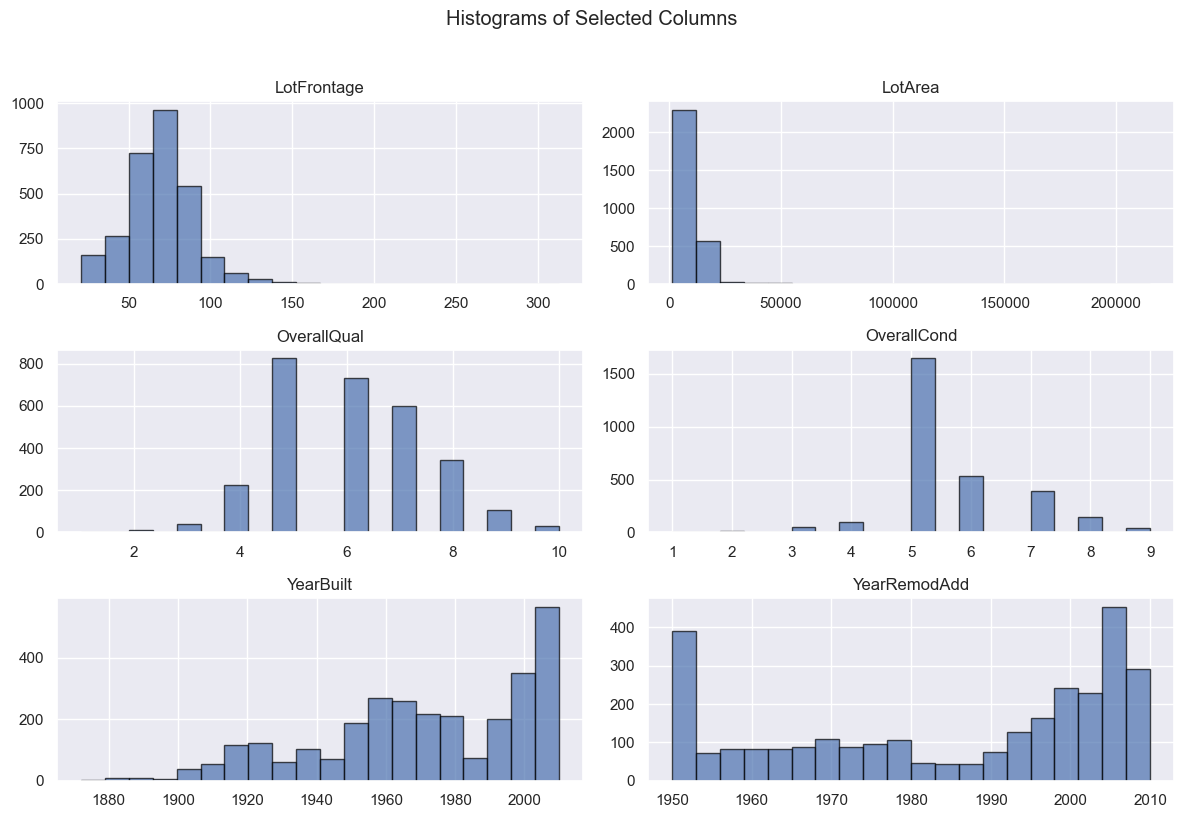

In [43]:
# Select the first three columns for demonstration
selected_columns = combined_df.iloc[:, 1:7]

# Create histograms for the selected columns
selected_columns.hist(bins=20, edgecolor='black', alpha=0.7, figsize=(12, 8))
plt.suptitle('Histograms of Selected Columns', y=1.02)  # Add a title at the top
plt.tight_layout()
plt.show()

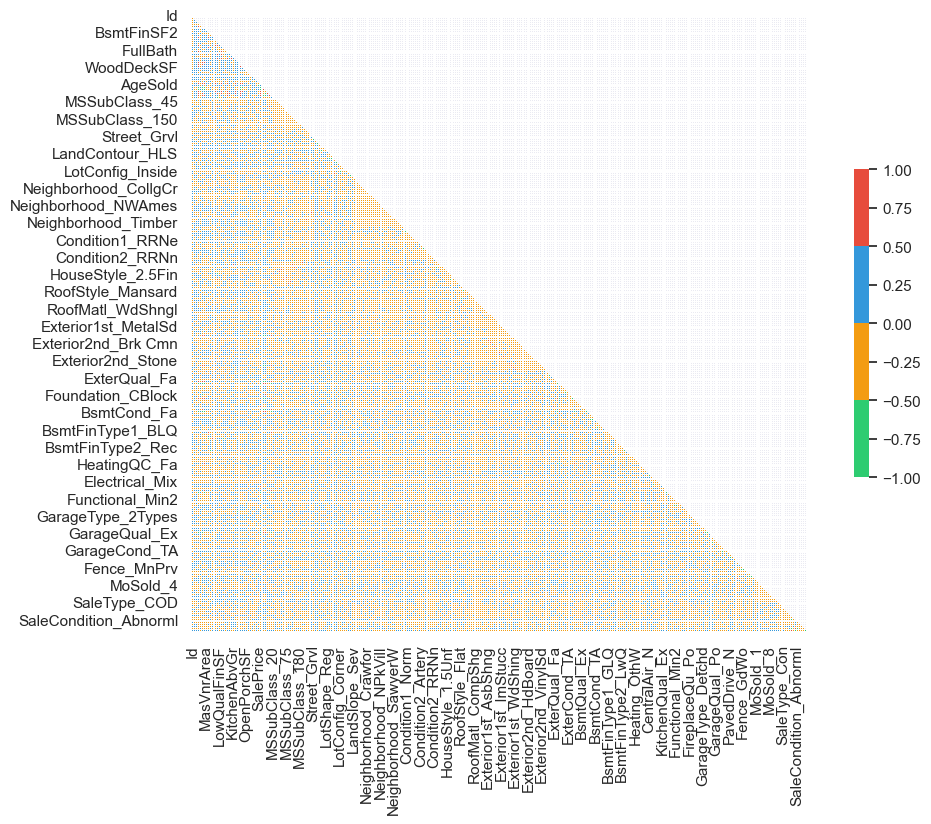

In [56]:
from matplotlib.colors import ListedColormap

# Correlation matrix
corr_mat = combined_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

# Set your custom colors
colors = ["#2ecc71", "#f39c12", "#3498db", "#e74c3c"]  # Example colors (modify as needed)

# Create a ListedColormap
custom_cmap = ListedColormap(sns.color_palette(colors).as_hex())

# Create the heatmap with the custom colormap
sns.heatmap(corr_mat, mask=mask, cmap=custom_cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

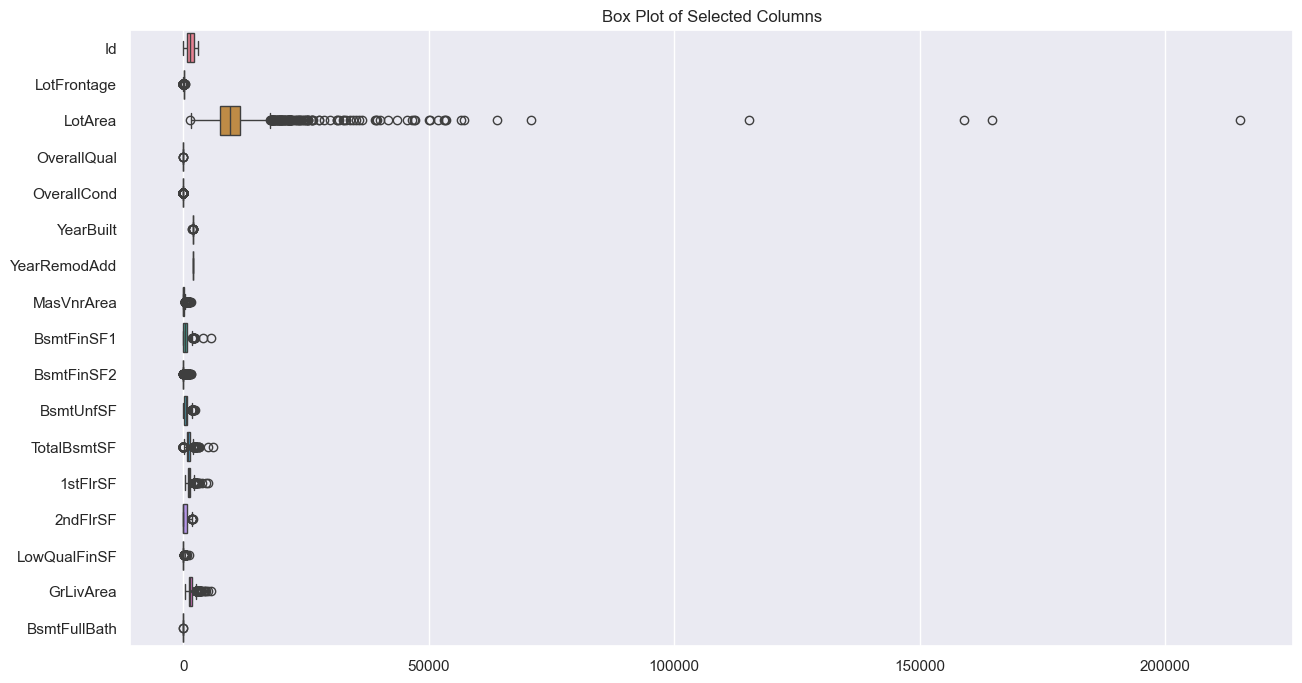

In [75]:
# Box plot for selected columns 
selected_columns_boxplot = combined_df.iloc[:, :17]  
# Create a box plot
plt.figure(figsize=(15, 8))
sns.boxplot(data=selected_columns_boxplot, orient='h')
plt.title('Box Plot of Selected Columns')
plt.show()

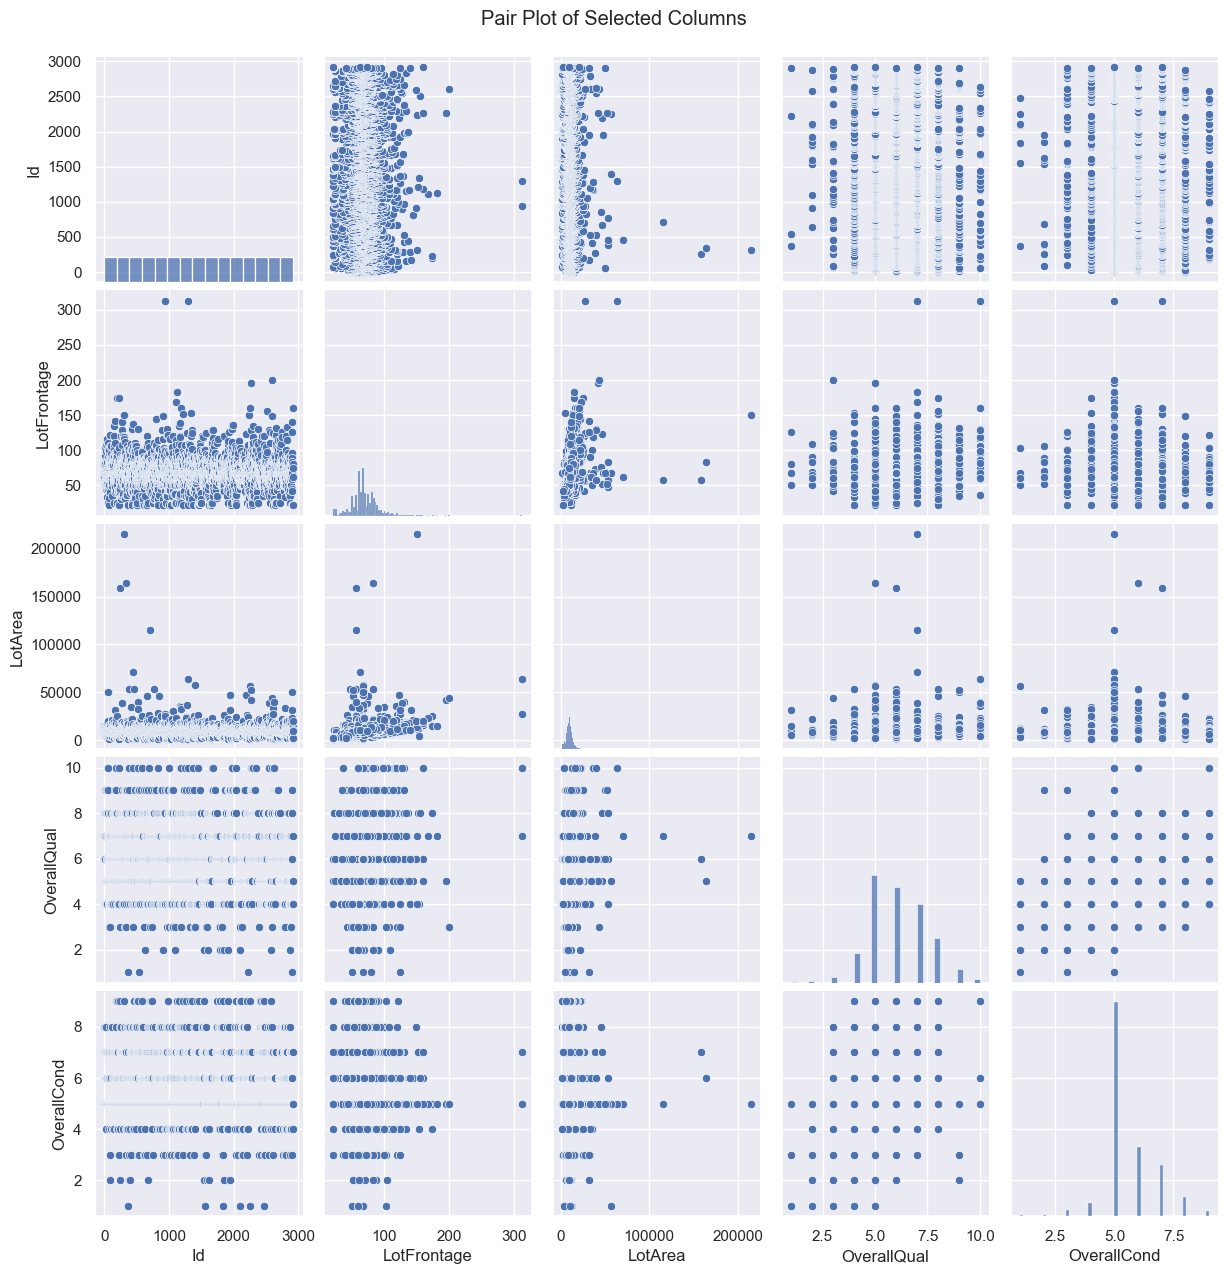

In [47]:
# Pair plot for selected columns (adjust column indices as needed)
selected_columns_pairplot = combined_df.iloc[:, :5]  # Selecting the first 5 columns for demonstration

# Create a pair plot
sns.pairplot(selected_columns_pairplot)
plt.suptitle('Pair Plot of Selected Columns', y=1.02)
plt.show()

In [79]:
##T-tests (for continuous variables):

from scipy.stats import ttest_ind

group1 = combined_df['YearBuilt']
group2 = combined_df['YearRemodAdd']

res = ttest_ind(group1, group2)

print(res)


TtestResult(statistic=-19.015646227110587, pvalue=2.8303030318955513e-78, df=5836.0)


In [77]:
##Chi-square tests (for categorical variables):

from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(combined_df['SaleCondition_AdjLand'], combined_df['SaleCondition_Abnorml'])
chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

print(p_value)

0.7416926315729544


In [82]:
from scipy.stats import describe

group1 = combined_df['LotArea']
res = describe(group1)

print(res)

DescribeResult(nobs=2919, minmax=(1300, 215245), mean=10168.11408016444, variance=62204711.56854398, skewness=12.822431401556724, kurtosis=264.4966320739909)


In [10]:
# Add and change some variables, namely the "Year" ones as it would be better to have them as "Age"
year = datetime.date.today().year
combined_df["AgeSold"] = int(year) - combined_df["YrSold"].astype(int)
combined_df["AgeGarage"] = int(year) - combined_df["GarageYrBlt"].astype(int)
combined_df["AgeBuilt"] = int(year) - combined_df["YearBuilt"].astype(int)

In [11]:
# Add some features related to total area of the house
combined_df['TotalArea'] = combined_df['TotalBsmtSF'] + combined_df['1stFlrSF'] + combined_df['2ndFlrSF'] + combined_df['GrLivArea'] +combined_df['GarageArea']
combined_df['Bathrooms'] = combined_df['FullBath'] + combined_df['HalfBath']/2
combined_df['Year average']= (combined_df['YearRemodAdd']+combined_df['YearBuilt'])/2

c:\Users\Louay Medhat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 92.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Louay Medhat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 71.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Louay Medhat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Louay Medhat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 81.2% of the points cannot be placed; you may want to decrease the size of the markers or use s

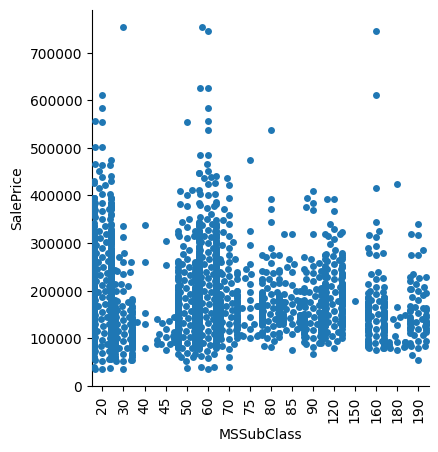

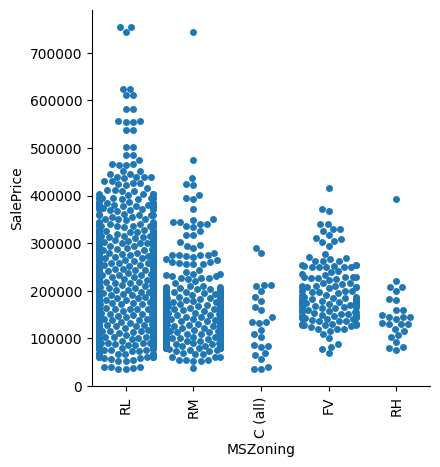

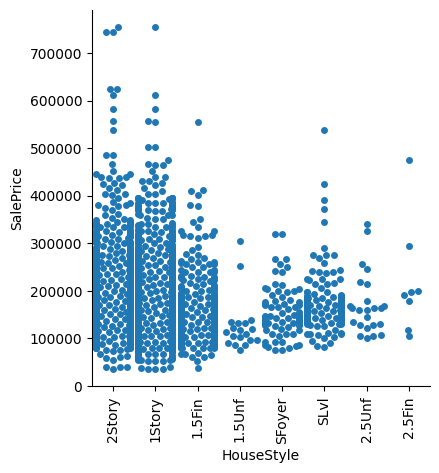

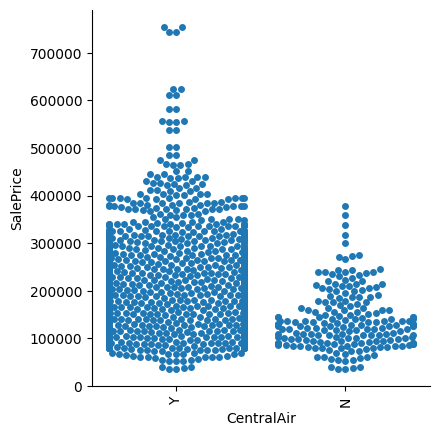

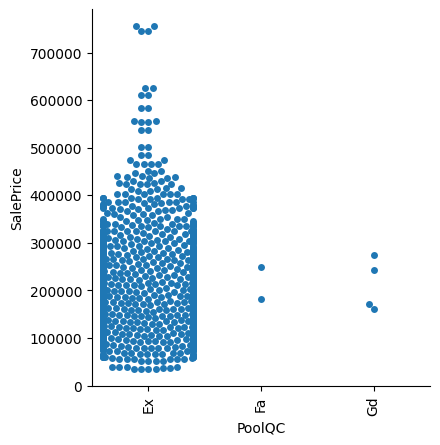

c:\Users\Louay Medhat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 94.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


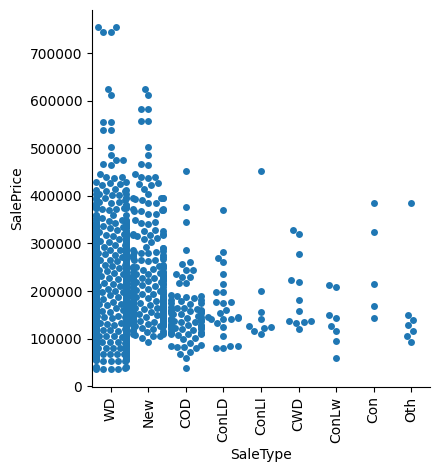

In [12]:
# Check the sale price distribution by different types of variables
for element in ["MSSubClass", "MSZoning", "HouseStyle","CentralAir", "PoolQC", "SaleType"]:
    cat_plot = sns.catplot(y="SalePrice", x= element, kind="swarm", legend="full", data=combined_df, height=4.5, aspect=1);
    cat_plot.set_xticklabels(rotation=90)

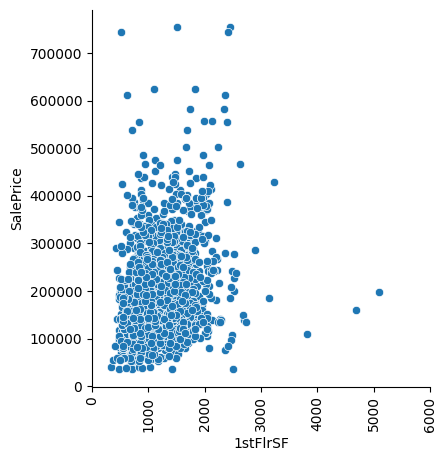

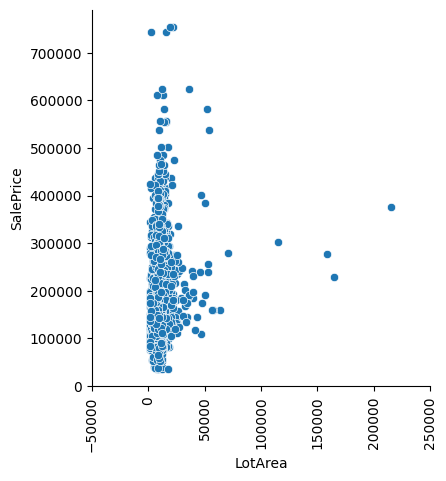

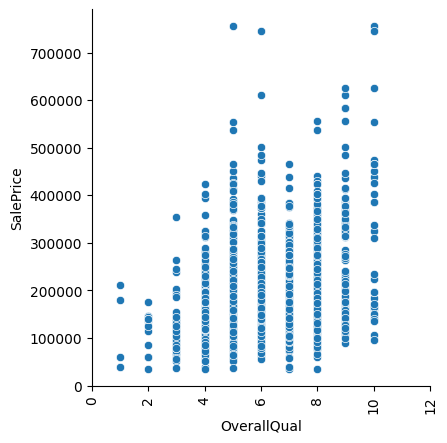

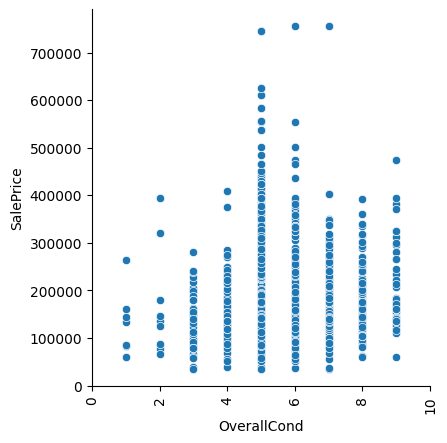

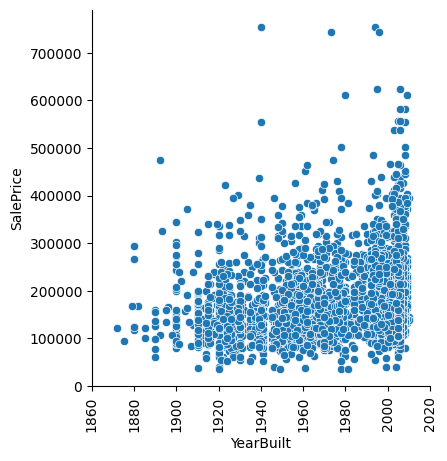

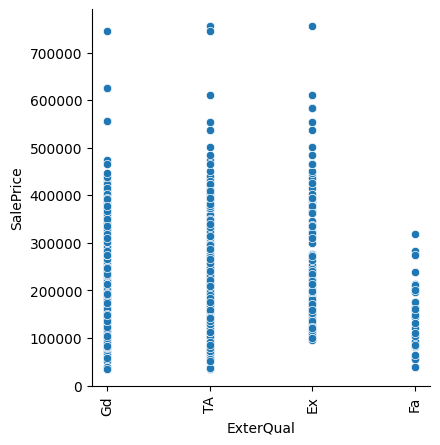

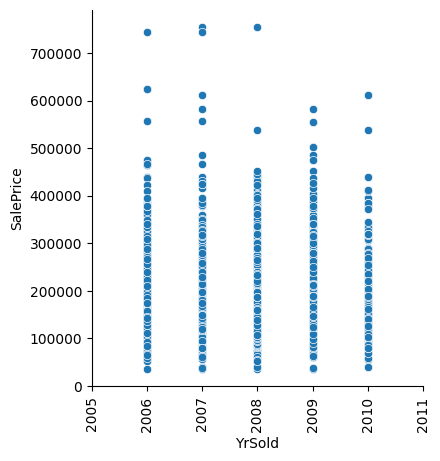

In [13]:
# Check the sale price distribution by different types of variables
for element in ["1stFlrSF", "LotArea", "OverallQual", "OverallCond", "YearBuilt","ExterQual", "YrSold"]:
    re_plot = sns.relplot(y="SalePrice", x= element, legend="full", data=combined_df, height=4.5, aspect=3 / 3,);
    re_plot.set_xticklabels(rotation=90)

In [14]:
# Get dummies for our data set
combined_df = pd.get_dummies(combined_df)

In [15]:
# Split the data set so to build our model
train_df = combined_df[combined_df["SalePrice"] > 0 ]
test_df = combined_df[combined_df["SalePrice"].isna() ]
test_df = test_df.drop(["SalePrice"], axis = 1)

# Create the X and y sets
X_train_df = train_df.drop(["SalePrice"], axis = 1)
y_train_df = train_df[["Id" ,"SalePrice"]]

In [16]:
# Log transform the SalePrice as it is skewed
y_train_df["SalePrice"] = np.log1p(y_train_df["SalePrice"])

C:\Users\Louay Medhat\AppData\Local\Temp\ipykernel_4512\2524520233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_df["SalePrice"] = np.log1p(y_train_df["SalePrice"])


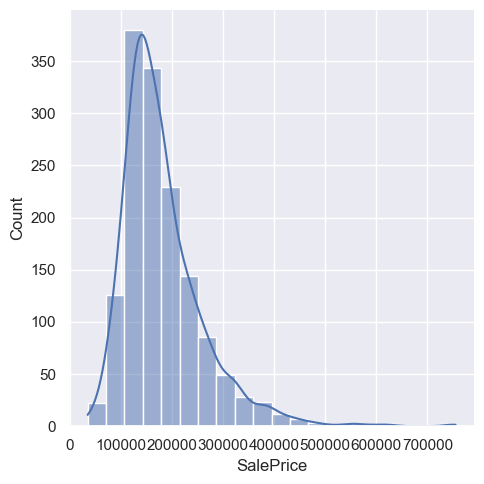

In [17]:
sns.set(rc={'figure.figsize':(12,8)})
sns.displot(combined_df['SalePrice'],kde = True, bins = 20)

In [18]:
# Set the ID col as index
for element in [X_train_df, y_train_df, test_df]:
    element.set_index('Id', inplace = True)

In [19]:
# Scale the data and use RobustScaler to minimize the effect of outliers
scaler = RobustScaler()

# Scale the X_train set
X_train_scaled = scaler.fit_transform(X_train_df.values)
X_train_df = pd.DataFrame(X_train_scaled, index = X_train_df.index, columns= X_train_df.columns)

# Scale the X_test set
X_test_scaled = scaler.transform(test_df.values)
X_test_df = pd.DataFrame(X_test_scaled, index = test_df.index, columns= test_df.columns)

In [20]:
# Feature selection (only keep variables with some variance)
#threshold_n=0.55
#sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))
#sel_var=sel.fit_transform(X_train_df)

# Create the new datasets
#X_train_df = X_train_df[X_train_df.columns[sel.get_support(indices=True)]]
#X_test_df = X_test_df[X_test_df.columns[sel.get_support(indices= True)]]

# Check what we have
#print(X_train_df.info())

In [21]:
# Split our training set into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_train_df, y_train_df, test_size=0.05, random_state=23)

In [22]:
# REGULARIZATION WITH LASSO
# Set parameters to iterate over
parameters= {'alpha':[0.0001,0.0009,0.001,0.002,0.003,0.01,0.1,1,10,100]}

# Instantiate reg for gridsearch
lasso=Lasso()
# Conduct the gridsearch
lasso_reg = GridSearchCV(lasso, param_grid=parameters, scoring='neg_mean_squared_error', cv=15)

# Instantiate new lasso reg with best params
lasso_reg = Lasso(alpha= 0.0009)

# Fit the model to the data
lasso_reg.fit(X_train,y_train)

# Predict on the test set from our training set
y_pred = lasso_reg.predict(X_test)
print("LassoRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

# Create predictions
predictions = np.exp(lasso_reg.predict(X_test_df))
my_pred_lasso = pd.DataFrame({'Id': X_test_df.index, 'SalePrice': predictions})

# Create CSV file
my_pred_lasso.to_csv('pred_lasso.csv', index=False)

LassoRegressor RMSE: 0.1484092276487173


In [23]:
# XGBOOST

# Grid search for best params
param_grid = {'max_depth':[3,4],
          'learning_rate':[0.01,0.03],
          'min_child_weight':[1,3],
          'reg_lambda':[0.1,0.5],
          'reg_alpha':[1,1.5],      
          'gamma':[0.1,0.5],
          'subsample':[0.4,0.5],
         'colsample_bytree':[0.4,0.5],
}

# Instantiate reg for gridsearch
reg = XGBRegressor()

# Conduct the gridsearch
grid_search = GridSearchCV(estimator = reg, param_grid = param_grid,
                          cv = 4, n_jobs = -1, verbose = True)

# Fit the grid search to the data
grid_search.fit(X_train_df, y_train_df)
print(grid_search.best_params_)

# Create a regressor with best parameters
xgb_reg = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3,min_child_weight=0, 
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', 
nthread=-1, scale_pos_weight=1, seed=27,reg_alpha=0.00006)

# Fit the model to the data
xgb_reg.fit(X_train, y_train)

# Predict on the test set from our training set
y_pred = xgb_reg.predict(X_test)
print("XGBoostRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

# Create predictions
predictions = np.exp(xgb_reg.predict(X_test_df))
my_pred_xgb = pd.DataFrame({'Id': X_test_df.index, 'SalePrice': predictions})

# Create CSV file
my_pred_xgb.to_csv('pred_xgb.csv', index=False)

Fitting 4 folds for each of 256 candidates, totalling 1024 fits
{'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 0.1, 'subsample': 0.5}
XGBoostRegressor RMSE: 0.14684342034178657


In [24]:
# NEURAL NETWORK

# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(32, activation = 'relu', input_dim = 319))

# Adding the second hidden layer
model.add(Dense(units = 317, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 300, activation = 'relu'))

# Adding the fourth hidden layer
model.add(Dense(units = 200, activation = 'relu'))

# Adding the fifth hidden layer
model.add(Dense(units = 200, activation = 'relu'))

# Adding the sixth hidden layer
model.add(Dense(units = 100, activation = 'relu'))

# Adding the seventh hidden layer
model.add(Dense(units = 100, activation = 'relu'))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the ANN to the Training set
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=10, epochs=200)

y_pred = model.predict(X_test)
print("ANNRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

# Create predictions
predictions = np.exp(model.predict(X_test_df))
predictions = np.concatenate( predictions, axis=0 )
my_pred_ann = pd.DataFrame({'Id': X_test_df.index, 'SalePrice': predictions})

# Create CSV file
my_pred_ann.to_csv('pred_ann.csv', index=False)

Epoch 1/200
139/139 [==============================] - 2s 4ms/step - loss: 52.1127 - val_loss: 16.2371
Epoch 2/200
139/139 [==============================] - 0s 2ms/step - loss: 30.9787 - val_loss: 9.0488
Epoch 3/200
139/139 [==============================] - 0s 2ms/step - loss: 11.7630 - val_loss: 4.9670
Epoch 4/200
139/139 [==============================] - 0s 2ms/step - loss: 7.2985 - val_loss: 4.8876
Epoch 5/200
139/139 [==============================] - 0s 2ms/step - loss: 19.7429 - val_loss: 7.2816
Epoch 6/200
139/139 [==============================] - 0s 2ms/step - loss: 14.0629 - val_loss: 3.3337
Epoch 7/200
139/139 [==============================] - 0s 2ms/step - loss: 6.2833 - val_loss: 2.0103
Epoch 8/200
139/139 [==============================] - 0s 2ms/step - loss: 4.7091 - val_loss: 2.2846
Epoch 9/200
139/139 [==============================] - 0s 2ms/step - loss: 3.4767 - val_loss: 0.4974
Epoch 10/200
139/139 [==============================] - 0s 2ms/step - loss: 3.3665 - 

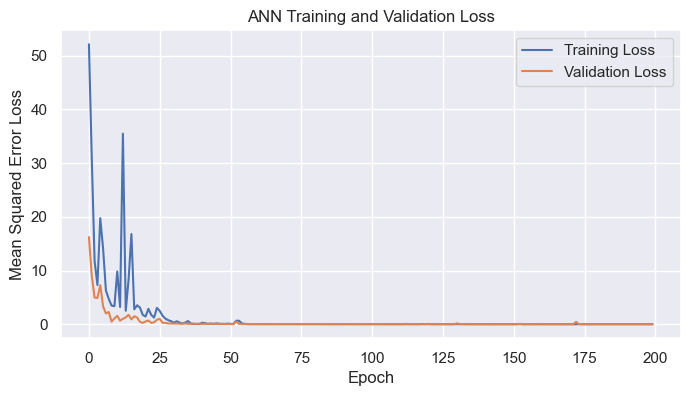

In [25]:
# Plot training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ANN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()

In [26]:
# LIGHTGBM
# Instantiate reg
lgbm_reg = lgbm.LGBMRegressor(
    objective='regression',
    num_leaves=4,
    learning_rate=0.01,
    n_estimators=5000,
    max_bin=200,
    bagging_fraction=0.75,
    bagging_freq=5,
    bagging_seed=7,
    feature_fraction=0.2,
    feature_fraction_seed=7,
    verbose=-1,
    #min_data_in_leaf=2,
    #min_sum_hessian_in_leaf=11
)

# Fit the model to the data
lgbm_reg.fit(X_train, y_train)

# Predict on the test set from our training set
y_pred = lgbm_reg.predict(X_test)
print("LGBMRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

# Create predictions
predictions = np.exp(lgbm_reg.predict(X_test_df))
my_pred_lgbm = pd.DataFrame({'Id': X_test_df.index, 'SalePrice': predictions})

# Create CSV file
my_pred_lgbm.to_csv('pred_lgbm.csv', index=False)

LGBMRegressor RMSE: 0.14034900408685913


In [27]:
# SVM
# Instantiate reg
svr_reg = make_pipeline(RobustScaler(), SVR(
    C=20,
    epsilon=0.008,
    gamma=0.0003,
))

# Fit the model to the data
svr_reg.fit(X_train, y_train)

# Predict on the test set from our training set
y_pred = svr_reg.predict(X_test)
print("SVRRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

# Create predictions
predictions = np.exp(svr_reg.predict(X_test_df))
my_pred_svr = pd.DataFrame({'Id': X_test_df.index, 'SalePrice': predictions})

# Create CSV file
my_pred_svr.to_csv('pred_svr.csv', index=False)

c:\Users\Louay Medhat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVRRegressor RMSE: 0.18398620434091398


In [28]:
# STACKED REGRESSION

# Instantiate reg
stregr = StackingRegressor(regressors=[xgb_reg, lgbm_reg, lasso_reg, lgbm_reg],meta_regressor=lgbm_reg, use_features_in_secondary=True )
# Fit the model to the data
stack_reg=stregr.fit(X_train, y_train)

# Predict on the test set from our training set
y_pred = stack_reg.predict(X_test)
print("StackedRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

# Create predictions
predictions = np.exp(stack_reg.predict(X_test_df))
my_pred_stacked = pd.DataFrame({'Id': X_test_df.index, 'SalePrice': predictions})

# Create CSV file
my_pred_stacked.to_csv('pred_stacked.csv', index=False)

c:\Users\Louay Medhat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


StackedRegressor RMSE: 0.1392536766429481


c:\Users\Louay Medhat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
c:\Users\Louay Medhat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


LightGBM is the best model with loss : 0.14034